<a href="https://colab.research.google.com/github/MucaCirone/Master_Thesis/blob/main/ConvergenceEulerScheme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ReLU_phi(a,b,c):
  # a, b, c = K_{t,t}, K_{t,s}, K_{s,s}
  kappa = np.max([np.min([b/np.sqrt(a*c), 1]), -1]) # Need the min due to numerical errors
  return (np.sqrt(1 - kappa**2) + (np.pi - np.arccos(kappa)*kappa))*np.sqrt(a*c)/(2*np.pi)

def erf_phi(a,b,c):
  # a, b, c = K_{t,t}, K_{t,s}, K_{s,s}
  return (2/np.pi)*np.arcsin(b/(np.sqrt((a+0.5)*(c+0.5))))

def exp_phi(a, b, c, sigma = 4.):
  # a, b, c = K_{t,t}, K_{t,s}, K_{s,s}
  return np.exp((a + 2*b + c)/(2*sigma**2))

def id_phi(a, b, c):
  # a, b, c = K_{t,t}, K_{t,s}, K_{s,s}
  return b

In [3]:
def print_K(K, interval_x, interval_y, contour = False):

  X, Y = np.meshgrid(interval_x, interval_y)
  T = interval_x.shape[0]
  Z = K

  if not contour:
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('surface')

  if contour:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.contour3D(X, Y, Z, 50)#, cmap='binary')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');

In [90]:
import plotly.graph_objects as go

def print_K_go(K, interval_x, interval_y):

  x, y = interval_x, interval_y
  z = K

  fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
  fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
  fig.update_layout(autosize=False,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))
  fig.show()

$$
  K_{t+1,s+1}^{x,y} = K_{t+1,s}^{x,y} + K_{t,s+1}^{x,y} - K_{t,s}^{x,y} + \phi_{ReLU}(K_{t,t}^{x,x},K_{t,s}^{x,y},K_{s,s}^{y,y})⟨Δ x_t , Δ y_s ⟩
$$

where
$$
Δ x_t = x_{t+1} - x_t
$$

In [4]:
def K_same(x, phi):

  Delta_x = np.diff(x)
  T = Delta_x.shape[0]

  K = np.ones((T+1,T+1))

  for t in range(T):
    for s in range(t):
      K[t+1, s+1] = K[t+1, s] + K[t, s+1] - K[t,s] + phi(K[t, t],K[t, s],K[s, s])*Delta_x[t]*Delta_x[s]
      K[s+1, t+1] = K[t+1, s+1]

      #if np.isnan(K[t+1, s+1]) :
      #  print(t,s)
      #  print(K[t, t],K[t, s],K[s, s] )

    K[t+1,t+1] = 2*K[t+1,t] - K[t,t] + phi(K[t, t],K[t, t],K[t, t])*Delta_x[t]*Delta_x[t]

  return K

In [5]:
def Kxy(x, y, phi, Kxx, Kyy):

  Delta_x = np.diff(x)
  Delta_y = np.diff(y)

  T_x = Delta_x.shape[0]
  T_y = Delta_y.shape[0]

  K = np.ones((T_x+1,T_y+1))

  for t in range(T):

    for s in range(t):
      K[t+1, s+1] = K[t+1, s] + K[t, s+1] - K[t,s] + phi(Kxx[t, t],K[t, s],Kyy[s, s])*Delta_x[t]*Delta_y[s]

    for s in range(t+1):
      K[s+1, t+1] = K[s+1, t] + K[s, t+1] - K[s,t] + phi(Kxx[s, s],K[s, t],Kyy[t, t])*Delta_x[s]*Delta_y[t]


  return K

In [96]:
# Inputs
T = 100
interval_x = np.linspace(0,1,T+1)
interval_y = interval_x
x = np.sin(interval_x)
y = np.cos(10*interval_y + np.exp(interval_x))

# phi \in {ReLU_phi, erf_phi, exp_phi, id_phi}
phi_ = [ReLU_phi, erf_phi, exp_phi, id_phi]
phi = ReLU_phi

# Compute Kernel Matrices
Kxx = K_same(x, phi)
Kyy = K_same(y, phi)
K = Kxy(x, y, phi, Kxx, Kyy)

print_K_go(Kyy, interval_x, interval_y)

In [74]:
# Inputs
T = 100
interval_x = np.linspace(0,1,T+1)
interval_y = interval_x
x = np.exp(0.5*np.sin(interval_x))
y = np.sin(10*interval_y)

# phi \in {ReLU_phi, erf_phi, exp_phi, id_phi}
phi_set = [ReLU_phi, erf_phi, exp_phi, id_phi]

Ks = []

for phi in phi_set:

  # Compute Kernel Matrices
  Kxx = K_same(x, phi)
  Kyy = K_same(y, phi)
  K = Kxy(x, y, phi, Kxx, Kyy)

  Ks = Ks + [[K, Kxx, Kyy]]

In [91]:
print_K_go(Ks[0][0], interval_x, interval_y)

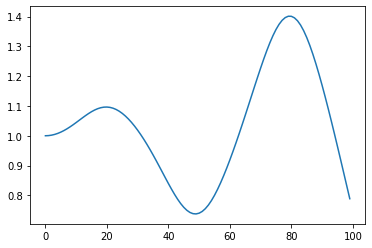

In [39]:
plt.plot([Ks[0][0][t,t] for t in range(T)])

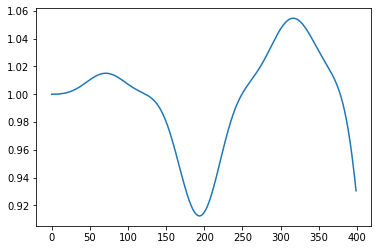

In [9]:
plt.plot([(Ks[0][0][t,t])/(Ks[1][0][t,t]) for t in range(T)])

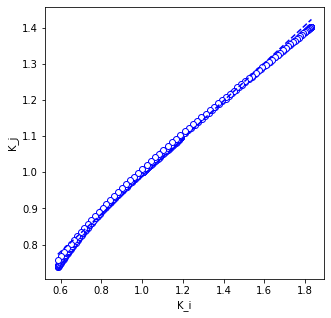

In [27]:
i, j = 3, 0
xs = [(Ks[i][0][t,t]) for t in range(T)]
ys = [(Ks[j][0][t,t]) for t in range(T)]

plt.figure(figsize=(5,5))

plt.scatter(xs, ys, edgecolors='blue', color='white')
plt.plot(np.unique(xs), np.poly1d(np.polyfit(xs, ys, 1))(np.unique(xs)), color='blue', ls='--')
plt.xlabel('K_i')
plt.ylabel('K_j')
plt.show()

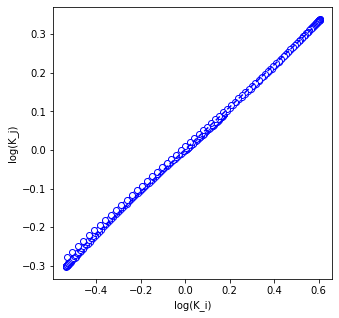

In [28]:
plt.figure(figsize=(5,5))

plt.scatter(np.log(xs), np.log(ys), edgecolors='blue', color='white')
plt.plot(np.unique(np.log(xs)), np.poly1d(np.polyfit(np.log(xs), np.log(ys), 1))(np.unique(np.log(xs))), color='blue', ls='--')
plt.xlabel('log(K_i)')
plt.ylabel('log(K_j)')
plt.show()

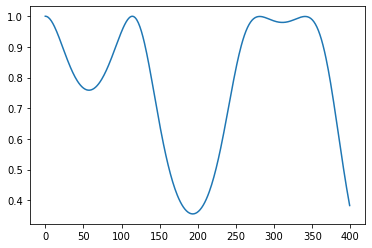

In [10]:
plt.plot([Ks[-1][0][t,t]/np.sqrt(Ks[-1][1][t,t]*Ks[-1][2][t,t]) for t in range(T)])